Używam pliku: C:\STUDIA\SEM2\MK\Lab3\war1.csv

Podgląd danych (pierwsze 5 wierszy):


,x1,x2,y
0,1,2,0.0
1,3,6,0.0
2,5,10,0.0
3,7,14,0.0
4,9,18,0.0



=== Współczynniki ===
SVD : a = 0.000000, b = 0.000000
pinv: a = 0.000000, b = 0.000000

=== Metryki ===
RMSE = 0.000000
R^2  = nan
cond_number(A) = 1.540469e+16


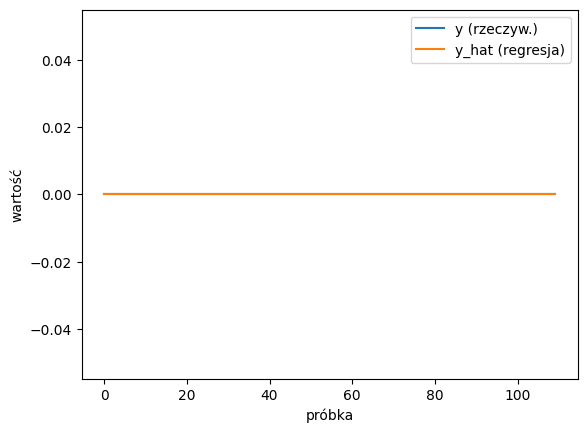

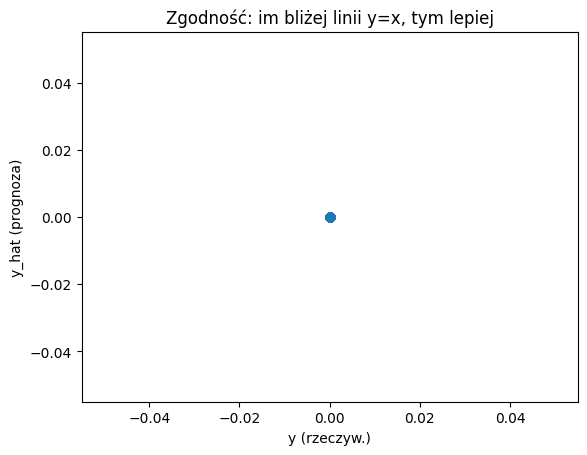

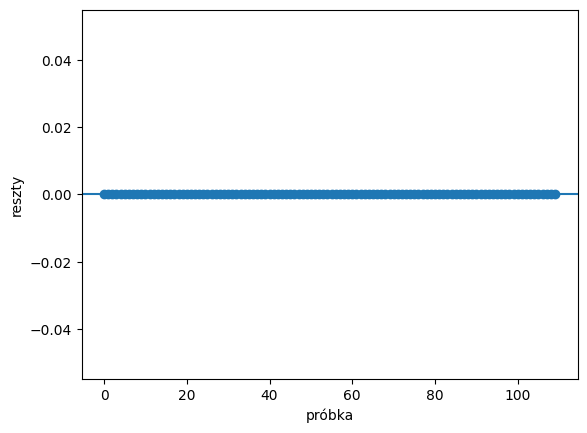

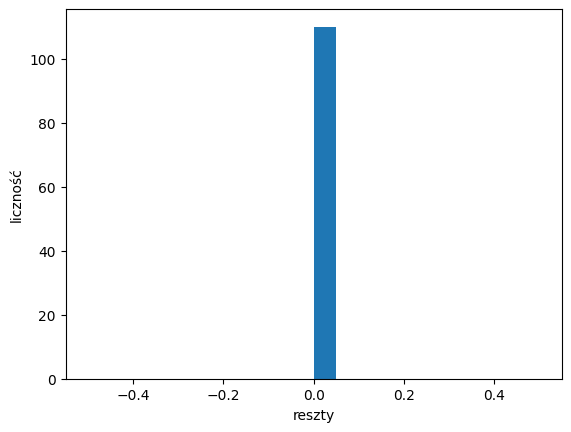

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#0 Ścieżka do pliku
FILENAME = "war1.csv"
WAR1_PATH = None 

def resolve_path():
    if isinstance(WAR1_PATH, (str, Path)):
        p = Path(WAR1_PATH)
        if p.exists():
            return p.resolve()
        raise FileNotFoundError(f"Nie ma pliku pod WAR1_PATH: {p}")
    p = Path(FILENAME)
    if p.exists():
        return p.resolve()
    # prosta próba znalezienia w ./data lub ..
    for cand in [Path("data")/FILENAME, Path("..")/FILENAME, Path("..")/"data"/FILENAME]:
        if cand.exists():
            return cand.resolve()
    raise FileNotFoundError(
        f"Nie znalazłem '{FILENAME}'. Umieść plik obok notatnika albo ustaw WAR1_PATH."
    )

path = resolve_path()
print(f"Używam pliku: {path}")

#1 Wczytanie + konwersja polskich przecinków dziesiętnych
df = pd.read_csv(path, sep=None, engine="python")

for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        try:
            df[col] = (
                df[col].astype(str)
                        .str.replace(",", ".", regex=False)
                        .str.replace(" ", "", regex=False)
            )
            df[col] = pd.to_numeric(df[col], errors="raise")
        except Exception:
            pass

#2 Wybór kolumn x1, x2, y
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def pick_col(cands, pool):
    for c in cands:
        if c in pool:
            return c
    return None

x1_col = "x1" if "x1" in num_cols else pick_col(["x1","X1"], num_cols)
x2_col = "x2" if "x2" in num_cols else pick_col(["x2","X2"], num_cols)
y_col  = pick_col(["y","Y","y2","target","output"], num_cols)
if y_col is None:
    rem = [c for c in num_cols if c not in {x1_col, x2_col}]
    y_col = rem[0] if rem else None

assert x1_col and x2_col and y_col, f"Brak trzech kolumn numerycznych x1,x2,y. Numeryczne: {num_cols}"

work = df[[x1_col, x2_col, y_col]].copy()
work.columns = ["x1","x2","y"]

print("\nPodgląd danych (pierwsze 5 wierszy):")
display(work.head())

#3 Regresja LS bez interceptu (SVD i pinv)
A = work[["x1","x2"]].to_numpy(dtype=float)
b = work["y"].to_numpy(dtype=float).reshape(-1,1)

U, S, VT = np.linalg.svd(A, full_matrices=False)
Sinv = np.diag(1.0 / S)
x_svd = VT.T @ Sinv @ U.T @ b
a_svd, b_svd = float(x_svd[0,0]), float(x_svd[1,0])

x_pinv = np.linalg.pinv(A) @ b
a_pinv, b_pinv = float(x_pinv[0,0]), float(x_pinv[1,0])

#4 Metryki
y_hat = (A @ x_svd).ravel()
residuals = (b.ravel() - y_hat)
ss_res = float(np.sum(residuals**2))
ss_tot = float(np.sum((b.ravel() - np.mean(b))**2))
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else float("nan")
rmse = float(np.sqrt(np.mean(residuals**2)))
cond_number = float(np.max(S) / np.min(S))

print("\n=== Współczynniki ===")
print(f"SVD : a = {a_svd:.6f}, b = {b_svd:.6f}")
print(f"pinv: a = {a_pinv:.6f}, b = {b_pinv:.6f}")

print("\n=== Metryki ===")
print(f"RMSE = {rmse:.6f}")
print(f"R^2  = {r2}")
print(f"cond_number(A) = {cond_number:e}")

#5 Wykresy
plt.figure()
plt.plot(b.ravel(), label="y (rzeczyw.)")
plt.plot(y_hat, label="y_hat (regresja)")
plt.xlabel("próbka"); plt.ylabel("wartość"); plt.legend()
plt.show()

plt.figure()
plt.scatter(b.ravel(), y_hat)
plt.xlabel("y (rzeczyw.)"); plt.ylabel("y_hat (prognoza)")
minv = float(min(np.min(b), np.min(y_hat))); maxv = float(max(np.max(b), np.max(y_hat)))
plt.plot([minv, maxv], [minv, maxv])  # linia y = x
plt.title("Zgodność: im bliżej linii y=x, tym lepiej")
plt.show()

plt.figure()
plt.plot(residuals, marker="o", linestyle="")
plt.axhline(0)
plt.xlabel("próbka"); plt.ylabel("reszty")
plt.show()

plt.figure()
plt.hist(residuals, bins=20)
plt.xlabel("reszty"); plt.ylabel("liczność")
plt.show()
